In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.fft as fft
import scipy.signal.windows as windows
import copy
import scipy.integrate as integrate
import scipy.special as sp
import scipy
from uvtools import dspec
from uvtools.data import DATA_PATH
import time
%matplotlib notebook

In this notebook

 * We demonstrate the use of `dspec.fourier_filter`. 
 * We compare the performance of three methods for linear spectral-domain foreground subtraction (and filtering) supported by `dspec.fourier_filter`. 
 
We perform all of our tests on a standard IDR2 flagging pattern over 246, 235 kHz channels. 



In [2]:
#load in data and flags
simfile = np.load(DATA_PATH + '/simulation_baseline_ant1_23_ant2_27_baseline_len_58.43m.npz')
data = simfile['data']
freqs = simfile['freqs']
lsts = simfile['lsts'] * 12. / np.pi 
flags = simfile['flags']
hi = simfile['hi']

Show the simulated data and flags. 

<IPython.core.display.Javascript object>


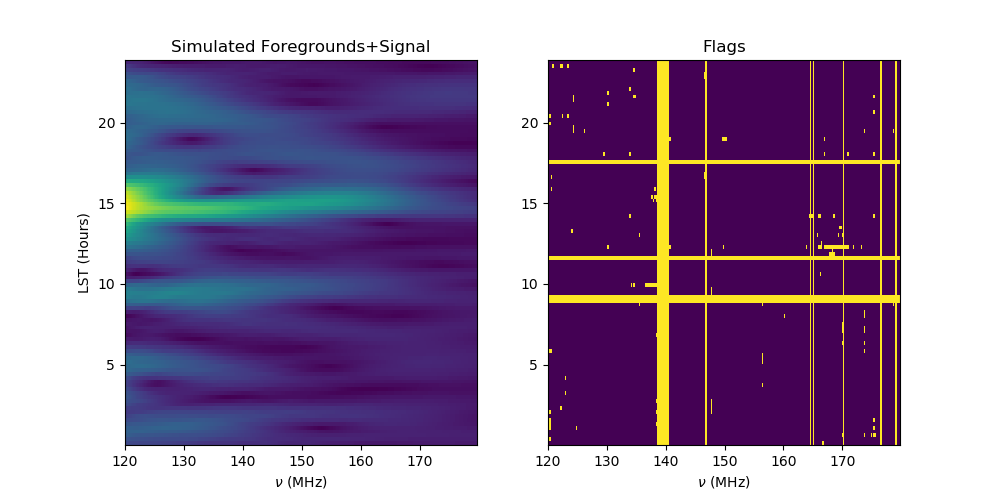

In [3]:
fig, axarr = plt.subplots(1,2)
plt.sca(axarr[0])
plt.imshow(np.abs(data), extent=[freqs.min()/1e6, freqs.max()/1e6, lsts.min(), lsts.max()])
plt.gca().set_aspect('auto')
plt.gca().set_xlabel('$\\nu$ (MHz)')
plt.gca().set_ylabel('LST (Hours)')
plt.gca().set_title('Simulated Foregrounds+Signal')
plt.sca(axarr[1])
plt.imshow(flags, extent=[freqs.min()/1e6, freqs.max()/1e6, lsts.min(), lsts.max()])
plt.gca().set_aspect('auto')
plt.gca().set_xlabel('$\\nu$ (MHz)')
plt.gca().set_title('Flags')


plt.gcf().set_size_inches(10,5)

Now let's compare ${\tt DAYENU}$, ${\tt DFT}$, and ${\tt DPSS}$. 

In [19]:
MYCACHE = {}
bl_delay = 58.43 / 3e8


#first generate dayenu foregrounds
t0 = time.time()
model_day, resid_day, info_day = dspec.fourier_filter(x=freqs, data=data, wgts=(~flags).astype(float), 
                                                      mode='dayenu', filter_centers=[0.], skip_wgt=0.15,
                                                      filter_half_widths = [bl_delay], suppression_factors = [1e-9],
                                                      filter2d=False, fitting_options={'eigenval_cutoff':[1e-12]}, cache=MYCACHE)
t1 = time.time()
info_day['runtime'] = t1 - t0

MYCACHE={}

t0 = time.time()
model_day_d, resid_day_d, info_day_d = dspec.fourier_filter(x=freqs, data=data, wgts=(~flags).astype(float), 
                                                      mode='dayenu_dpss_leastsq', filter_centers=[0.], skip_wgt=0.15,
                                                      filter_half_widths = [bl_delay], suppression_factors = [1e-9],
                                                      filter2d=False, fitting_options={'eigenval_cutoff':[1e-12]}, cache=MYCACHE)
t1 = time.time()
info_day_d['runtime'] = t1 - t0
MYCACHE={}

t0 = time.time()
model_dftm, resid_dftm, info_dftm = dspec.fourier_filter(x=freqs, data=data, wgts=(~flags).astype(float),
                                                     mode='dft_matrix', cache=MYCACHE, suppression_factors=[1e-9], 
                                                     filter2d=False, skip_wgt=0.15,
                                                     fitting_options={'fundamental_period':1.5*(freqs[-1]-freqs[0])},
                                                     filter_centers=[0.], filter_half_widths=[bl_delay])
t1 = time.time()
info_dftm['runtime'] = t1 - t0
MYCACHE={}

t0 = time.time()
model_dftl, resid_dftl, info_dftl = dspec.fourier_filter(x=freqs, data=data, wgts=(~flags).astype(float),
                                                     mode='dft_leastsq', cache=MYCACHE, suppression_factors=[1e-9], 
                                                     filter2d=False, skip_wgt=0.15,
                                                     fitting_options={'fundamental_period':1.5*(freqs[-1]-freqs[0])},
                                                     filter_centers=[0.], filter_half_widths=[bl_delay])
t1 = time.time()
info_dftl['runtime'] = t1 - t0
MYCACHE={}




t0 = time.time()
model_dpssl, resid_dpssl, info_dpssl = dspec.fourier_filter(x=freqs, data=data, wgts=(~flags).astype(float),
                                                     mode='dpss_leastsq', cache=MYCACHE, suppression_factors=[1e-9], 
                                                     filter2d=False, skip_wgt=0.15,
                                                     fitting_options={'eigenval_cutoff':[1e-12]},
                                                     filter_centers=[0.], filter_half_widths=[bl_delay])
t1 = time.time()
info_dpssl['runtime'] = t1 - t0
MYCACHE={}


t0 = time.time()
model_dpssm, resid_dpssm, info_dpssm = dspec.fourier_filter(x=freqs, data=data, wgts=(~flags).astype(float),
                                                     mode='dpss_matrix', cache=MYCACHE, suppression_factors=[1e-9], 
                                                     filter2d=False, skip_wgt=0.15,
                                                     fitting_options={'eigenval_cutoff':[1e-12]},
                                                     filter_centers=[0.], filter_half_widths=[bl_delay])
t1 = time.time()
info_dpssm['runtime'] = t1 - t0
MYCACHE={}




(100, 256)
(100, 256)


<IPython.core.display.Javascript object>


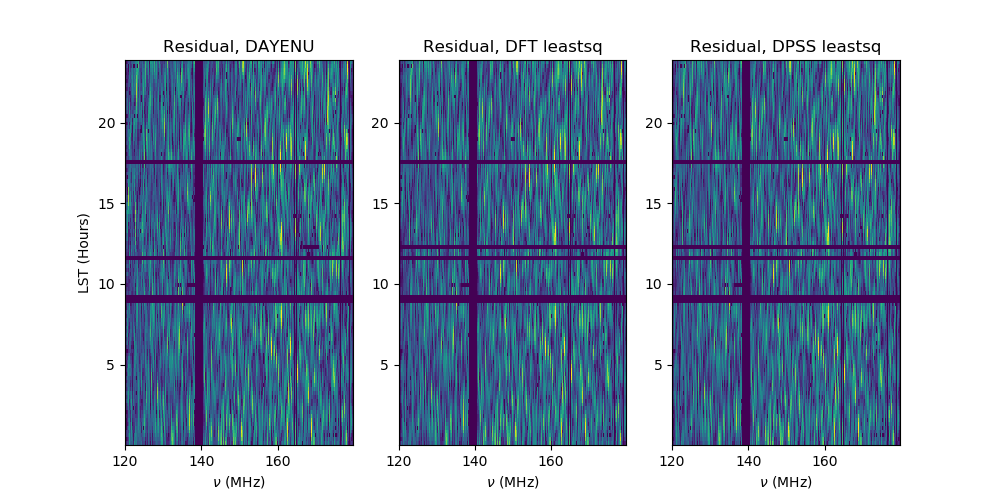

In [20]:
fig, axarr = plt.subplots(1,3)
plt.sca(axarr[0])
plt.imshow(np.abs(resid_day*(~flags).astype(float)), extent=[freqs.min()/1e6, freqs.max()/1e6, lsts.min(), lsts.max()], vmin=0, vmax=1.6e-3)
plt.gca().set_aspect('auto')
plt.gca().set_xlabel('$\\nu$ (MHz)')
plt.gca().set_ylabel('LST (Hours)')
plt.gca().set_title('Residual, DAYENU')

plt.sca(axarr[1])
plt.imshow(np.abs(resid_dftl*(~flags).astype(float)), extent=[freqs.min()/1e6, freqs.max()/1e6, lsts.min(), lsts.max()], vmin=0, vmax=1.6e-3)
plt.gca().set_aspect('auto')
plt.gca().set_xlabel('$\\nu$ (MHz)')
plt.gca().set_title('Residual, DFT leastsq')

plt.sca(axarr[2])
plt.imshow(np.abs(resid_dpssl*(~flags).astype(float)), extent=[freqs.min()/1e6, freqs.max()/1e6, lsts.min(), lsts.max()], vmin=0, vmax=1.6e-3)
plt.gca().set_aspect('auto')
plt.gca().set_xlabel('$\\nu$ (MHz)')
plt.gca().set_title('Residual, DPSS leastsq')

plt.gcf().set_size_inches(10,5)

Note that the DFT matrix residuals look icky. This is because inverting $A^T W A$ is poorly conditioned. I don't know why. 

<IPython.core.display.Javascript object>


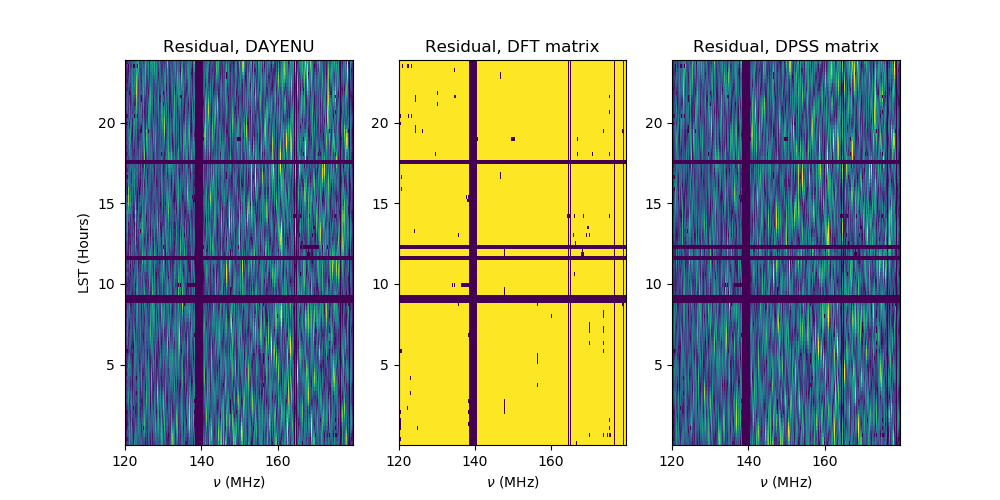

In [21]:
fig, axarr = plt.subplots(1,3)
plt.sca(axarr[0])
plt.imshow(np.abs(resid_day*(~flags).astype(float)), extent=[freqs.min()/1e6, freqs.max()/1e6, lsts.min(), lsts.max()], vmin=0, vmax=1.6e-3)
plt.gca().set_aspect('auto')
plt.gca().set_xlabel('$\\nu$ (MHz)')
plt.gca().set_ylabel('LST (Hours)')
plt.gca().set_title('Residual, DAYENU')

plt.sca(axarr[1])
plt.imshow(np.abs(resid_dftm*(~flags).astype(float)), extent=[freqs.min()/1e6, freqs.max()/1e6, lsts.min(), lsts.max()], vmin=0, vmax=1.6e-3)
plt.gca().set_aspect('auto')
plt.gca().set_xlabel('$\\nu$ (MHz)')
plt.gca().set_title('Residual, DFT matrix')

plt.sca(axarr[2])
plt.imshow(np.abs(resid_dpssm*(~flags).astype(float)), extent=[freqs.min()/1e6, freqs.max()/1e6, lsts.min(), lsts.max()], vmin=0, vmax=1.6e-3)
plt.gca().set_aspect('auto')
plt.gca().set_xlabel('$\\nu$ (MHz)')
plt.gca().set_title('Residual, DPSS matrix')

plt.gcf().set_size_inches(10,5)

<IPython.core.display.Javascript object>


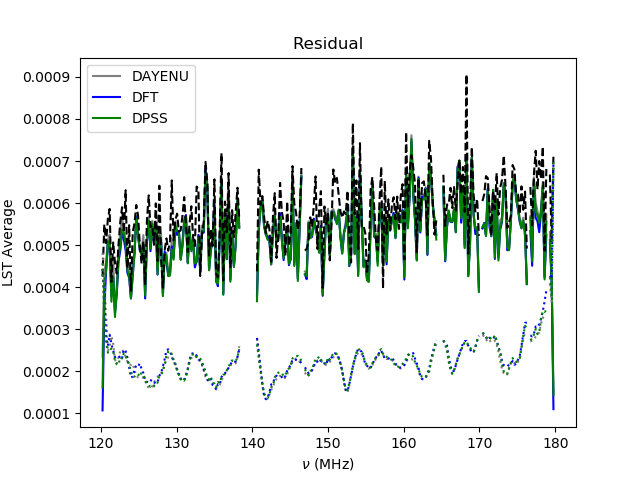

/Users/aewallwi/miniconda3/envs/hera3dev/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/aewallwi/miniconda3/envs/hera3dev/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/Users/aewallwi/miniconda3/envs/hera3dev/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/Users/aewallwi/miniconda3/envs/hera3dev/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/Users/aewallwi/miniconda3/envs/hera3dev/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/Users/aewallwi/miniconda3/envs/hera3dev/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in tr

In [22]:
plt.figure()
plt.plot(freqs / 1e6, np.sum(np.abs(resid_day*(~flags).astype(float)), 
                             axis=0)/np.sum((~flags).astype(float), axis=0), label='DAYENU', color='grey')
plt.plot(freqs / 1e6, np.sum(np.abs(resid_dftl*(~flags).astype(float)), 
                             axis=0)/np.sum((~flags).astype(float), axis=0), label='DFT', color='blue')
plt.plot(freqs / 1e6, np.sum(np.abs(resid_dpssl*(~flags).astype(float)), 
                             axis=0)/np.sum((~flags).astype(float), axis=0), label='DPSS', color='green')

plt.gca().set_aspect('auto')
plt.gca().set_xlabel('$\\nu$ (MHz)')
plt.gca().set_ylabel('LST Average')
plt.gca().set_title('Residual')

plt.legend()

plt.plot(freqs / 1e6, np.sum(np.abs(hi*(~flags).astype(float)),
                        axis=0)/np.sum((~flags).astype(float), axis=0),
                        label='Simulated Signal', ls='--', color='k')

plt.plot(freqs / 1e6, np.sum(np.abs((hi-resid_day)*(~flags).astype(float)), 
                             axis=0)/np.sum((~flags).astype(float), axis=0), label='DAYENU', color='grey',ls=':')
plt.plot(freqs / 1e6, np.sum(np.abs((hi-resid_dftl)*(~flags).astype(float)), 
                             axis=0)/np.sum((~flags).astype(float), axis=0), label='DFT', color='blue',ls=':')
plt.plot(freqs / 1e6, np.sum(np.abs((hi-resid_dpssl)*(~flags).astype(float)), 
                             axis=0)/np.sum((~flags).astype(float), axis=0), label='DPSS', color='green', ls=':')



<IPython.core.display.Javascript object>


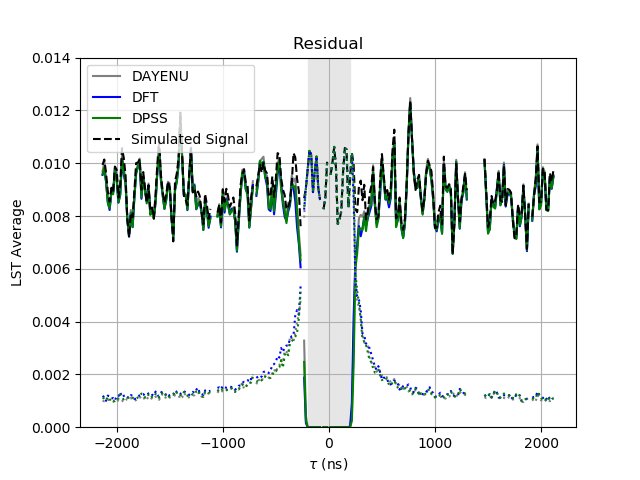

/Users/aewallwi/miniconda3/envs/hera3dev/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/Users/aewallwi/miniconda3/envs/hera3dev/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/Users/aewallwi/miniconda3/envs/hera3dev/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/aewallwi/miniconda3/envs/hera3dev/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/Users/aewallwi/miniconda3/envs/hera3dev/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/Users/aewallwi/miniconda3/envs/hera3dev/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
/Users/aewall

(0.0, 0.014)

In [23]:
plt.figure()
plt.fill_between([-bl_delay*1e9, bl_delay*1e9], [0, 0], [0.014,0.014], color=[0.9,0.9,0.9])
dlys = fft.fftshift(fft.fftfreq(freqs.shape[0], freqs[1]-freqs[0]))
plt.plot(dlys*1e9, fft.fftshift(np.sum(np.abs(fft.fft(resid_day*(~flags).astype(float), axis=1)), 
                             axis=0)/np.sum((~flags).astype(float), axis=0)), label='DAYENU', color='grey')
plt.plot(dlys*1e9, fft.fftshift(np.sum(np.abs(fft.fft(resid_dftl*(~flags).astype(float), axis=1)), 
                             axis=0)/np.sum((~flags).astype(float), axis=0)), label='DFT', color='blue')
plt.plot(dlys*1e9, fft.fftshift(np.sum(np.abs(fft.fft(resid_dpssl*(~flags).astype(float), axis=1)), 
                             axis=0)/np.sum((~flags).astype(float), axis=0)), label='DPSS', color='green')

plt.plot(dlys*1e9, fft.fftshift(np.sum(np.abs(fft.fft(hi*(~flags).astype(float), axis=1)),
                                      axis=0)/np.sum((~flags).astype(float), axis=0)), label='Simulated Signal', ls='--', color='k')

plt.legend()

plt.plot(dlys*1e9, fft.fftshift(np.sum(np.abs(fft.fft((hi-resid_day)*(~flags).astype(float), axis=1)), 
                             axis=0)/np.sum((~flags).astype(float), axis=0)), label='DAYENU', color='grey',ls=':')
plt.plot(dlys*1e9, fft.fftshift(np.sum(np.abs(fft.fft((hi-resid_dftl)*(~flags).astype(float), axis=1)), 
                             axis=0)/np.sum((~flags).astype(float), axis=0)), label='DFT', color='blue',ls=':')
plt.plot(dlys*1e9, fft.fftshift(np.sum(np.abs(fft.fft((hi-resid_dpssl)*(~flags).astype(float), axis=1)), 
                             axis=0)/np.sum((~flags).astype(float), axis=0)), label='DPSS', color='green',ls=':')

plt.gca().set_aspect('auto')
plt.gca().set_xlabel('$\\tau$ (ns)')
plt.gca().set_ylabel('LST Average')
plt.gca().set_title('Residual')
plt.grid()
plt.ylim(0., 0.014)
#plt.gcf().set_size_inches(10,5)

Here are the runtimes for each technique averaged over the number of baseline-times. Note that caching is employed for all matrix inversion techniques but even so, the leastsq methods win out (out least for for these numbers of channels). The number of DPSS terms being fitted is 35 while the number of DFT modes being fitted is 47. This difference will become more pronounced if larger bandwidths are used (for large bandwidth, the number of DFT modes necessary to subtract power should approach twice the number of DPSS modes).  

<IPython.core.display.Javascript object>


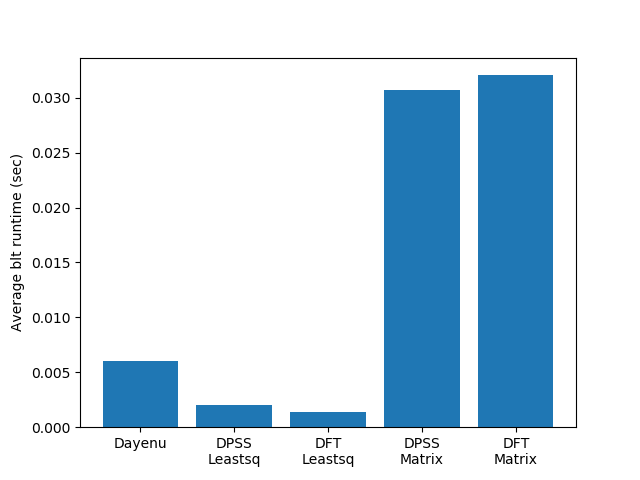

Text(0, 0.5, 'Average blt runtime (sec)')

In [24]:
plt.figure()
plt.bar([0,1,2,3,4],[info_day['runtime']/data.shape[0], info_dpssl['runtime']/data.shape[0], info_dftl['runtime']/data.shape[0],
                 info_dpssm['runtime']/data.shape[0], info_dftm['runtime']/data.shape[0]])
plt.gca().set_xticklabels(['', 'Dayenu', 'DPSS\nLeastsq', 'DFT\nLeastsq', 'DPSS\nMatrix', 'DFT\nMatrix'])
plt.ylabel('Average blt runtime (sec)')

In [25]:
print(info_dpssm[1][9]['nterms'])
print(2 * bl_delay * 2 * len(freqs) * np.median(np.diff(freqs)))

[35]
46.744
